In [1]:
import json
from collections import Counter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import requests
import tqdm
import datetime
import os

import seaborn as sns
from matplotlib import style
style.use('ggplot')

In [2]:
requests_get = requests.get

In [3]:
'''
import shelve
import atexit
from cachetools import cached
from functools import partial
cache = shelve.open('cache.shlv')
atexit.register(cache.close)
cache_key = lambda *args, **kwargs: json.dumps([args, kwargs], sort_keys=True)

requests_get = cached(cache, key=partial(cache_key, 'requests.get'))(
    requests_get)
'''

In [4]:
token = os.environ('VK_TOKEN')
vk_api_base = 'https://api.vk.com/method'

In [5]:
def get_data(domain, steps):
    p_list = []
    offset = 0
    count = 100
    for i in tqdm.tqdm(list(range(steps))):
        offset += count * i
        request = requests_get(vk_api_base + '/wall.get', params={
            'domain': domain,
            'offset': offset,
            'access_token': token,
            'count': count,
            'v': '5.92'
        })
        p_list.extend(request.json()['response']['items'])
    return p_list


posts = get_data('gamefit', 5)
posts[:5]

100%|██████████| 5/5 [00:00<00:00, 55.09it/s]


[{'id': 23370,
  'from_id': -104160764,
  'owner_id': -104160764,
  'date': 1557067087,
  'marked_as_ads': 0,
  'post_type': 'post',
  'text': 'Больше красивостей вам в ленту. 😉\n\nПроект нашего [id11159290|веб-разработчика].\n\nУверен найдутся желающие заполучить такую радость!',
  'copy_history': [{'id': 3,
    'owner_id': -181672337,
    'from_id': -181672337,
    'date': 1557066626,
    'post_type': 'post',
    'text': '#всемmysmys\n\nМы - MYSMYS. Сразу введём вас в курс дела: это от шведского mys [мюс] - уют. Так что в сумме - [мюс-мюс] :)\n\nМы - два энтузиаста из Сибири, которые решили, что могут сделать ваши жизни чуть лучше с помощью своих творений. Получится ли у нас - покажет время. А пока вот второй сделанный нами блокнот (ибо первый суперэксклюзив уже уехал к своему человеку). Пишите, что думаете, какие ещё обложки хотели бы видеть - мы очень открыты к обсуждениям. :)\n\nP.S. за репост вот этой самой записи скидка на первый заказ 15%. Чего же вы ждёте? 💙',
    'attachments

In [6]:
def get_comments(posts):
    c_list = []
    for post in tqdm.tqdm(posts):
        offset = 0
        comments_count = post['comments']['count']
        count = 100
        for i in range(comments_count // 100 + 1):
            offset += i * count
            request = requests_get(vk_api_base + '/wall.getComments', params={
                'owner_id': -104160764,
                'offset': offset,
                'access_token': token,
                'count': count,
                'v': '5.92',
                'post_id': post['id']
            })
            c_list.extend(request.json()['response']['items'])
    return c_list


comments = get_comments(posts)
comments[:5]

100%|██████████| 500/500 [00:00<00:00, 4123.70it/s]


[{'id': 23368,
  'from_id': 183116083,
  'post_id': 23367,
  'owner_id': -104160764,
  'parents_stack': [],
  'date': 1556793347,
  'text': 'Подкосили его полиэтиленовые палки 😬',
  'thread': {'count': 1,
   'items': [],
   'can_post': True,
   'show_reply_button': True,
   'groups_can_post': True}},
 {'id': 23349,
  'from_id': 9928633,
  'post_id': 23348,
  'owner_id': -104160764,
  'parents_stack': [],
  'date': 1556276645,
  'text': 'Ого, у вас еще столько снега. У нас уже почти лето. Но на майские немного похолодает.',
  'thread': {'count': 1,
   'items': [],
   'can_post': True,
   'show_reply_button': True,
   'groups_can_post': True}},
 {'id': 23351,
  'from_id': 12769797,
  'post_id': 23348,
  'owner_id': -104160764,
  'parents_stack': [],
  'date': 1556277193,
  'text': 'Хм, а будет ли решение в органайзере для Подлодки для счастливых обладателей полного фарша с Кика?)',
  'thread': {'count': 8,
   'items': [],
   'can_post': True,
   'show_reply_button': True,
   'groups_can_

In [7]:
def get_users(comments):
    ids_list = list(sorted(set((comment['from_id'] for comment in comments))))
    users = []
    count = 100
    for i in tqdm.tqdm(list(range(len(ids_list) // count))):
        request = requests_get(vk_api_base + '/users.get', params={
            'user_ids': ','.join(
                map(str, ids_list[i*count:(i + 1) * count])),
            'fields': 'sex,has_photo',
            'access_token': token,
            'v': '5.95',
        })
        users.extend(request.json()['response'])
    return users


users = get_users(comments)
users = {user['id']: user for user in users}
users

100%|██████████| 8/8 [00:00<00:00, 1789.28it/s]


{3419: {'id': 3419,
  'first_name': 'Anton',
  'last_name': 'Tkachenko',
  'is_closed': False,
  'can_access_closed': True,
  'sex': 2,
  'has_photo': 1},
 6390: {'id': 6390,
  'first_name': 'Kirill',
  'last_name': 'Zarubin',
  'is_closed': False,
  'can_access_closed': True,
  'sex': 2,
  'has_photo': 1},
 26359: {'id': 26359,
  'first_name': 'Vitya',
  'last_name': 'Semyonov',
  'is_closed': True,
  'can_access_closed': False,
  'sex': 2,
  'has_photo': 1},
 29527: {'id': 29527,
  'first_name': 'Philip',
  'last_name': 'Zhyoltikov',
  'is_closed': False,
  'can_access_closed': True,
  'sex': 2,
  'has_photo': 1},
 29590: {'id': 29590,
  'first_name': 'Viktor',
  'last_name': 'Kostin',
  'is_closed': False,
  'can_access_closed': True,
  'sex': 2,
  'has_photo': 1},
 39427: {'id': 39427,
  'first_name': 'Veronika',
  'last_name': 'Obidina',
  'is_closed': False,
  'can_access_closed': True,
  'sex': 1,
  'has_photo': 1},
 50762: {'id': 50762,
  'first_name': 'Vasily',
  'last_name': 

In [8]:
for comment in comments:
    comment['user_info'] = users.get(comment['from_id'])

In [9]:
def split_words(text):
    return text.split()


def count_average_comment_length(comments):
    words_num = Counter()
    for comment in comments:
        post_id = comment['post_id']
        words_num[post_id] += len(split_words(comment['text']))
    return {
        post_id: words_num[post_id]
        for post_id in words_num
    }


def count_avg_comment_to_post_length(posts, comments_lengths):
    post_lengths = Counter()
    comments_nums = Counter()
    for post in posts:
        comments_count = post['comments']['count']
        if comments_count == 0:
            continue

        post_id = post['id']
        text_len = len(split_words(post['text']))
        post_lengths[text_len] += comments_lengths[post_id]
        comments_nums[text_len] += comments_count

    return {
        text_len: post_lengths[text_len] / comments_nums[text_len]
        for text_len in post_lengths if text_len < 200
    }


comments_lengths = count_average_comment_length(comments)
# print(count_aver(words_num, posts))
count_posts_lengths = count_avg_comment_to_post_length(posts, comments_lengths)

In [10]:
def get_xy(values):
    return zip(*sorted(values.items()))

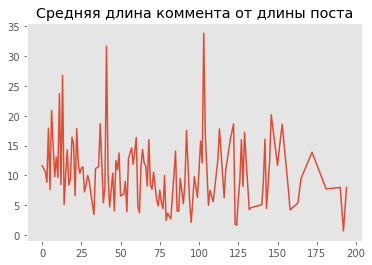

In [11]:
plt.grid()
plt.title('Средняя длина коммента от длины поста')
plt.plot(*get_xy(count_posts_lengths))

In [12]:
def count_avg_post_length_to_month(posts):
    post_lengths = Counter()
    post_counts = Counter()
    for post in posts:
        comments_count = post['comments']['count']
        if comments_count == 0:
            continue

        post_id = post['id']
        post_month = datetime.datetime.fromtimestamp(post['date']).month
        text_len = len(split_words(post['text']))

        post_lengths[post_month] += text_len
        post_counts[post_month] += 1

    return {
        month: post_lengths[month] / post_counts[month]
        for month in post_lengths
    }


avg_post_length_to_month = count_avg_post_length_to_month(posts)
avg_post_length_to_month

{5: 64.81818181818181,
 4: 69.22448979591837,
 3: 66.63461538461539,
 2: 54.94117647058823,
 1: 65.0,
 12: 66.0,
 11: 71.74117647058823,
 10: 67.50819672131148,
 9: 85.25641025641026,
 8: 76.8695652173913,
 7: 82.52,
 6: 69.6}

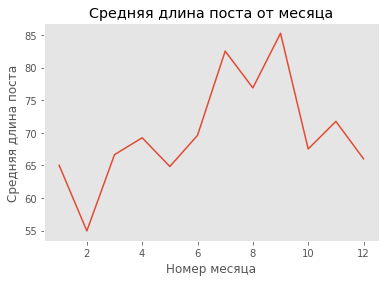

In [13]:
plt.grid()
plt.title('Средняя длина поста от месяца')
plt.xlabel('Номер месяца')
plt.ylabel('Средняя длина поста')
plt.plot(*get_xy(avg_post_length_to_month))

In [30]:
def count_avg_post_length_to_day(posts):
    post_lengths = Counter()
    post_counts = Counter()
    for post in posts:
        comments_count = post['comments']['count']
        if comments_count == 0:
            continue

        post_id = post['id']
        post_month = datetime.datetime.fromtimestamp(post['date']).day
        text_len = len(split_words(post['text']))

        post_lengths[post_month] += text_len
        post_counts[post_month] += 1

    return {
        month: post_lengths[month] / post_counts[month]
        for month in post_lengths
    }


avg_post_length_to_day = count_avg_post_length_to_day(posts)
avg_post_length_to_day

{2: 77.5,
 26: 81.58333333333333,
 19: 66.0625,
 18: 61.583333333333336,
 17: 53.36363636363637,
 15: 61.0,
 12: 38.46666666666667,
 10: 50.416666666666664,
 7: 74.55555555555556,
 6: 101.11111111111111,
 5: 111.5,
 3: 56.45454545454545,
 1: 63.94117647058823,
 31: 61.2,
 28: 79.92307692307692,
 27: 126.85714285714286,
 23: 46.81818181818182,
 21: 56.0,
 20: 106.66666666666667,
 11: 59.25,
 8: 85.93333333333334,
 25: 57.714285714285715,
 13: 61.142857142857146,
 4: 47.27272727272727,
 30: 77.45454545454545,
 24: 59.266666666666666,
 22: 51.5,
 14: 93.66666666666667,
 29: 98.75,
 16: 41.9,
 9: 83.28571428571429}

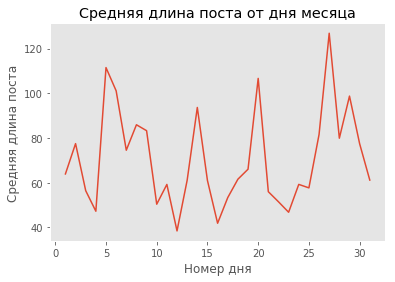

In [32]:
plt.grid()
plt.title('Средняя длина поста от дня месяца')
plt.xlabel('Номер дня')
plt.ylabel('Средняя длина поста')
plt.plot(*get_xy(avg_post_length_to_day))

In [16]:
def count_avg_comments_length_to_sex(comments):
    lengths = Counter()
    counts = Counter()
    for comment in comments:
        if comment['user_info'] is None:
            continue

        sex = comment['user_info'].get('sex')
        text_len = len(split_words(comment['text']))

        lengths[sex] += text_len
        counts[sex] += 1

    return {
        sex: lengths[sex] / counts[sex]
        for sex in lengths
    }


avg_comments_length_to_sex = count_avg_comments_length_to_sex(comments)
avg_comments_length_to_sex

{2: 11.383269312846778, 1: 8.23939393939394}

<BarContainer object of 2 artists>

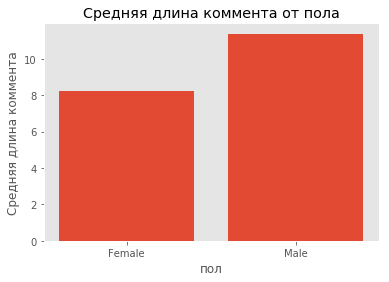

In [21]:
plt.grid()
plt.title('Средняя длина коммента от пола')
plt.xlabel('пол')
plt.ylabel('Средняя длина коммента')
x, y = get_xy(avg_comments_length_to_sex)
plt.bar(['Female', 'Male'], y)

In [24]:
def count_avg_comments_length_to_has(comments):
    lengths = Counter()
    counts = Counter()
    for comment in comments:
        if comment['user_info'] is None:
            continue

        has = comment['user_info'].get('has_photo')
        text_len = len(split_words(comment['text']))

        lengths[has] += text_len
        counts[has] += 1

    return {
        has: lengths[has] / counts[has]
        for has in lengths
    }


avg_comments_length_to_has = count_avg_comments_length_to_has(comments)
avg_comments_length_to_has

{1: 10.967840735068913, 0: 12.163934426229508}

<BarContainer object of 2 artists>

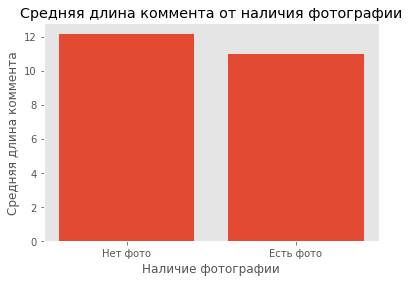

In [26]:
plt.grid()
plt.title('Средняя длина коммента от наличия фотографии')
plt.xlabel('Наличие фотографии')
plt.ylabel('Средняя длина коммента')
x, y = get_xy(avg_comments_length_to_has)
plt.bar(['Нет фото', 'Есть фото'], y)

In [29]:
texts = [
    post['text'] for post in posts
] + [
    comment['text'] for comment in comments
]
with open('texts.txt', 'w') as texts_file:
    texts_file.write('\n\n'.join(texts))